# Анализ сервиса аренды самокатов GoFast

**Описание проекта**
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

*без подписки:*

    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
*с подпиской Ultra:*

    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Описание данных**
В основных данных есть информация о пользователях, их поездках и подписках.

*Пользователи* — users_go.csv:

    - user_id	уникальный идентификатор пользователя
    - name	имя пользователя
    - age	возраст
    - city	город
    - subscription_type	тип подписки (free, ultra)

*Поездки* — rides_go.csv:

    - user_id	уникальный идентификатор пользователя
    - distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - date	дата совершения поездки

*Подписки* — subscriptions_go.csv:

    - subscription_type	тип подписки
    - minute_price	стоимость одной минуты поездки по данной подписке
    - start_ride_price	стоимость начала поездки
    - subscription_fee	стоимость ежемесячного платежа
    

**Порядок исследования**

Входные данные получены из разных файло. Качество предоставляемых данных никто гарантировать не может. Поэтому перед тем, как отвечать на вопрсоы исследования и делать вывод, понадобится обзор данных.

Проверим данные на пропуски, выбросы, дубли и оценим их влияние на исследование. Затем, на этапе предобработки, поищем возможность исправить самые критичные ошибки данных.

После ответа на поставленные цели исследования, сделаем общий вывод.

Таким образом, исследование пройдёт этапы:

    1) Обзор данных
    2) Предобработка данных
    3) Исследовательский анализ данных
    4) Объединение данных
    5) Подсчёт выручки
    6) Проверка гипотез
    7) Распределения
    8) Выводы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st
from math import factorial

pd.options.display.max_columns = 20

# Шаг 1. Загрузка данных

In [2]:
try:
    users_go = pd.read_csv('/datasets/users_go.csv') 
    rides_go = pd.read_csv('/datasets/rides_go.csv') 
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv') 
except:
    users_go = pd.read_csv('datasets/users_go.csv') 
    rides_go = pd.read_csv('datasets/rides_go.csv') 
    subscriptions_go = pd.read_csv('datasets/subscriptions_go.csv') 

**Проверяем, что данные загружены**

In [3]:
users_go.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users_go.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 412.6 KB


Датафрейм ‘users_go’ имеет 5 столбцов и 1565 строк без пропусков и выбросов. Вес датафрейма 412,6 Кб. Типы столбцов ‘user_id’, ‘age’, ‘subscription_type’ имеют не оптимальные типы данных, их корректировка может снизить вес датафрейма. Названия столбцов соответствуют ‘змеиному’ стилю. 

In [5]:
rides_go.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides_go.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.6 MB


В датафрейме ‘rides_go’ обнаружены 4 столбца и 18068 строк без пропусков. Вес датафрейма 1,6 Мб. Типы столбцов ‘user_id’ и ‘date’ не оптимальны. Корректировка типов этих столбцов снизит потребление памяти и позволит раскрыть их потенциал. Названия столбцов соответствуют ‘змеиному’ стилю. Возможно наличие выбросов в столбцах ‘distance’ и ‘duration’. Необходим анализ.

In [7]:
subscriptions_go.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions_go.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 299.0 bytes


В датафрейме обнаружены 4 столбца и 2 строки без пропусков. Не оптимальные типы данных во всех столбцах. Это не является критичным при весе датафрейма в 299 байт. Если тип данных в столбце ‘subscription_type’ датафрейма ‘users_go’ будет изменён, то и в данном датафрейме одноимённый столбец требуется привести в соответствие. Названия столбцов соответствуют ‘змеиному’ стилю.

# Шаг 2. Предобработка данных

**Рассмотрим количество пропусков в таблицах**

In [9]:
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [10]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [11]:
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Поменяем тип данных там, где это возможно**

In [12]:
# Корректировка столбцов в 'users_go'
users_go['user_id'] = users_go['user_id'].astype('uint16')
users_go['age'] = users_go['age'].astype('uint8')

In [13]:
#Приведем столбец date из датафрейма data_riders к типу даты.
rides_go['date'] = pd.to_datetime(rides_go['date'], format = '%Y-%m-%d')

In [14]:
rides_go['date'].head(10)

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
5   2021-10-09
6   2021-10-19
7   2021-11-06
8   2021-11-14
9   2021-11-22
Name: date, dtype: datetime64[ns]

In [15]:
#Проверим, за какой период предоставлены данные. 
rides_go['date'].dt.year.unique()

array([2021])

In [16]:
#Добавим номер месяца
rides_go['month'] = rides_go['date'].dt.month

In [17]:
rides_go['month'].head(10)

0     1
1     1
2     4
3     8
4     8
5    10
6    10
7    11
8    11
9    11
Name: month, dtype: int64

**Обработаем дубликаты**

In [18]:
users_go.duplicated().sum()

31

In [19]:
users_go.drop_duplicates(inplace=True)

In [20]:
users_go.duplicated().sum()

0

In [21]:
rides_go.duplicated().sum()

0

In [22]:
subscriptions_go.duplicated().sum()

0

**Итог**
1) Пропущенных данных в таблицах не обнаружено.

2) Удалены дубликаты в данных.

3) Добавлен столбец `month` с номер месяца.

# Шаг 3. Исследовательский анализ данных

**Используем функцию описательной статистики, чтобы посмотреть основные данные о наших датафреймах**

In [23]:
users_go.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


In [24]:
rides_go.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


In [25]:
subscriptions_go.describe()

,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


**Посмотрим как распределены пользователи по городам**

In [26]:
count_users_by_city = users_go['city'].value_counts()
count_users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [27]:
count_users_by_city['rate'] = round(users_go['city'].value_counts() / count_users_by_city.sum(), 2) * 100
count_users_by_city['rate']

Пятигорск         14.0
Екатеринбург      13.0
Ростов-на-Дону    13.0
Краснодар         13.0
Сочи              12.0
Омск              12.0
Тюмень            12.0
Москва            11.0
Name: city, dtype: float64

In [28]:
#Создадим функцию для вывода круговой диаграммы для users_go
def pie_function(column, title):
    users_go[column].value_counts().plot(kind='pie', y=count_users_by_city, autopct='%1.0f%%', figsize=(7,7), title=title)

In [29]:
#Создадим функцию для вывода гистограммы для users_go
def barh_function(column, title, xlabel, ylabel):
    users_go[column].value_counts(ascending=True).plot(kind='barh', y=count_users_by_city, figsize=(7,7), title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

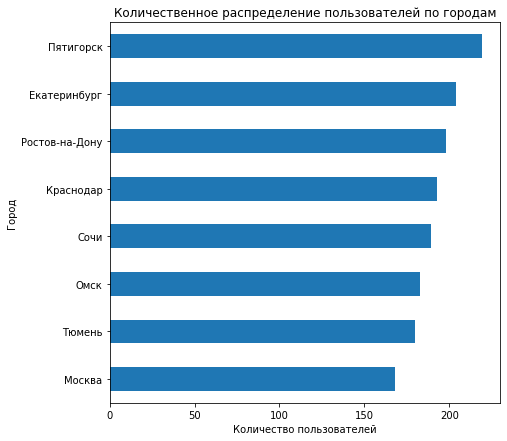

In [30]:
barh_function('city', 'Количественное распределение пользователей по городам', 'Количество пользователей', 'Город')

**Посмотрим на соотношение пользователей с подпиской и без подписки**

In [31]:
count_sub = users_go['subscription_type'].value_counts()
count_sub

free     835
ultra    699
Name: subscription_type, dtype: int64

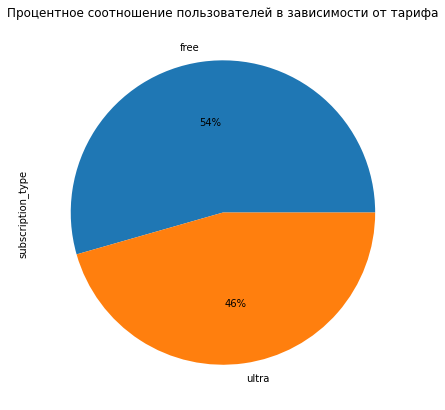

In [32]:
pie_function('subscription_type', 'Процентное соотношение пользователей в зависимости от тарифа')

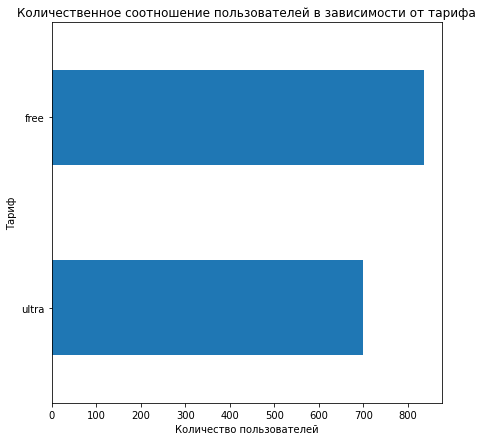

In [33]:
barh_function('subscription_type', 'Количественное соотношение пользователей в зависимости от тарифа', 
              'Количество пользователей', 'Тариф')

**Посмотрим на распределение возрастов пользователей**

In [34]:
#Создадим универсальную функцию распределения с построением гистограммы
def hist_function(data, title, xlabel, ylabel):
    plt.hist(data, bins = 30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

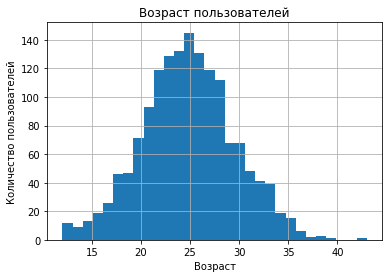

In [35]:
hist_function(users_go['age'], 'Возраст пользователей', 'Возраст', 'Количество пользователей')

**Оценим расстояние, которое пользователь преодолел за одну поездку**

In [36]:
#Создадим универсальную функцию ящика с усами
def boxplot_function(column, title, xlabel):
    sns.boxplot(x=rides_go[column], color='blue')
    plt.title(title)
    plt.xlabel(xlabel)

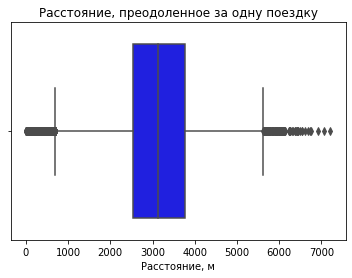

In [37]:
boxplot_function('distance', 'Расстояние, преодоленное за одну поездку', 'Расстояние, м')

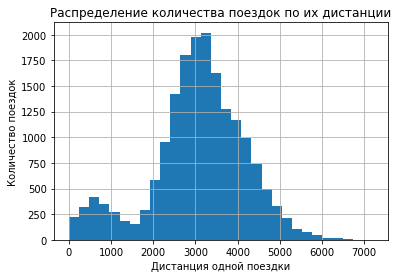

In [38]:
hist_function(rides_go['distance'], 'Распределение количества поездок по их дистанции', 'Дистанция одной поездки', 
              'Количество поездок')

Как мы видим, кроме основного распределения есть ещё и небольшой пик в начале графика. Это может быть связано с неверными данными или техническими сбоями в процессе взятия самоката. Также в ходе исследования было выяснено, что такое малое расстояние часто проезжают на платном тарифе, возможно чтобы быстро добраться из мест с плохой транспортной доступностью

**Оценим продолжительность поездок**

In [39]:
rides_go.groupby(['user_id']).sum(numeric_only = True)

,distance,duration,month
user_id,,,
1,34070.182066,204.604909,99
2,33964.058614,197.644279,67
3,36907.597866,233.193513,66
4,44837.189916,288.563581,107
5,35556.949649,174.073932,51
...,...,...,...
1530,46758.469822,292.366839,104
1531,67054.794222,408.192206,142
1532,33902.203192,212.160144,111


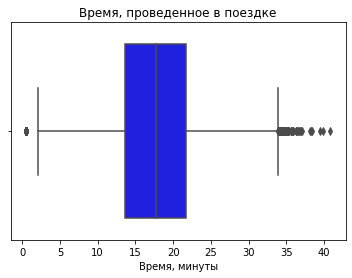

In [40]:
boxplot_function('duration', 'Время, проведенное в поездке', 'Время, минуты')

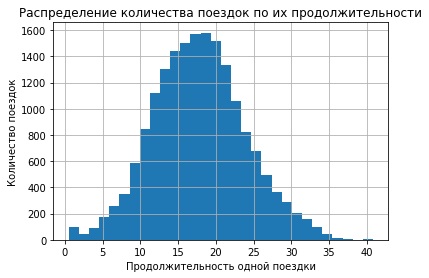

In [41]:
hist_function(rides_go['duration'], 'Распределение количества поездок по их продолжительности', 
              'Продолжительность одной поездки', 'Количество поездок')

**В самом начале графика виден пик. Проанализируем его на аномалии**

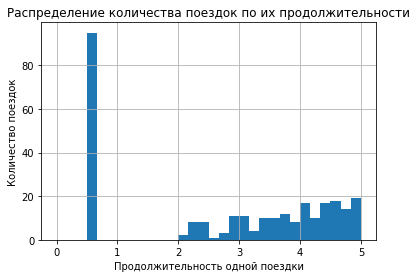

In [42]:
#Уменьшим анализируемый интервал
plt.hist(rides_go['duration'], bins = 30, range=(0, 5))
plt.title('Распределение количества поездок по их продолжительности')
plt.xlabel('Продолжительность одной поездки')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

In [43]:
#Посмотрим на медиану датасета по столбцу duration
rides_go['duration'].median()

17.678394530393803

In [44]:
#Посмотрим на вышеописанный выброс в длительности внимательнее
zero_duration = rides_go.loc[rides_go['duration'] < 2]
zero_duration.describe()

,user_id,distance,duration,month
count,95.000000,95.000000,95.0,95.000000
mean,1092.210526,5113.176549,0.5,6.484211
std,244.028551,658.254104,0.0,3.709858
min,701.000000,4030.308008,0.5,1.000000
25%,901.000000,4611.510820,0.5,3.000000
50%,1069.000000,5052.769411,0.5,6.000000
75%,1310.500000,5488.459099,0.5,10.000000
max,1524.000000,7211.007745,0.5,12.000000


Как мы видим, 95 поездок имеют продолжительность меньше 1 минуты, однако большую дистанцию - среднее и медиану более 5 км. Возможно таким образом была реализована какая-нибудь акция с бесплатными минутами и эти поездки нужно учитывать при расчете выручки как есть. Для анализа не достаточно данных, оставляем как есть.

**Вывод**

**Частота встречаемости городов**

Лидером по частотности является Пятигорск (219 строк). Следом идут Екатеринбург (204 строки) и Ростов-на-Дону (198 строк). Антилидер — Москва (168 строк). По данным не ясно верна ли выборка, но судя по ним компании стоит наращивать продвижение своего сервиса в Москве, как одном из крупнейших "потребителей" сервисов самокатов.

**Соотношение пользователей с подпиской и без подписки**

Пользователей с подпиской «free» всего 835, что составляет 54.43% от общего количества и на 136 больше, чем с подпиской «ultra» (699). Возможно компании стоит провести рекламную акцию для повышения доли подписчиков. Конечно это зависит от сезона и политики компании в отношении подписок, а также того, кто является бесплатным пользователем. Возможно это сотрудники компании или льготная группа граждан.

**Возраст пользователей**

Самыми младшими являются пользователи 12, 13 лет.

Самыми старшими - 43, 39.

Распределение возрастной кривой имеет нормальное распределение. Максимальное количество пользователей в возрасте 25 лет, этот же возраст является медианным.

В целом, основной возраст пользователей приложения укладывается в промежуток от 20 до 30 лет. 

**Расстояние, которое пользователь преодолел за одну поездку**

Самая короткая дистанция - 0.86 км.

Самая длинная - 7.2 км.

В основном пользователи проезжают от 2.5 км до 4 км, что соответствует как прогулочному маршруту, так и количество киллометров, которое обычному жителю города требуется, чтобы куда-то добраться.

В общем же, за одну поездку пользователи преодолевают от 1 до 7211 метров. Медиана всех значений равна 3133 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров.

**Продолжительность поездок**

Самые короткие поездки - по пол минуты. Возможно была акция с бесплатными минутами. Для анализа не достаточно данных, оставляем как есть.

Самая длинная поездка заняла 40 минут.

В основном же длительность поездки состовляет 13 - 22 минуты. 

# Шаг 4. Объединение данных

**Объединим данные в единый датафрейм**

In [45]:
full_data = users_go.merge(rides_go, on='user_id').merge(subscriptions_go, on='subscription_type')
full_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [46]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  uint16        
 1   name               18068 non-null  object        
 2   age                18068 non-null  uint8         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3), uint16(1), uint8(1)
memory usage: 1.6+ MB


In [47]:
len(full_data)

18068

In [48]:
len(users_go) + len(rides_go) + len(subscriptions_go)

19604

In [49]:
#Создадим датафрейм с данными о пользователях без подписки
free_sub = full_data.query("`subscription_type` == 'free'")
free_sub.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [50]:
free_sub.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,24.893326,3045.495282,17.390909,6.522994,8.0,50.0,0.0
std,241.165628,4.481100,1246.173806,6.326803,3.449770,0.0,0.0,0.0
min,700.000000,12.000000,0.855683,0.500000,1.000000,8.0,50.0,0.0
25%,915.000000,22.000000,2366.562689,12.958437,4.000000,8.0,50.0,0.0
50%,1123.000000,25.000000,3114.648465,17.326890,7.000000,8.0,50.0,0.0
75%,1328.000000,28.000000,3905.697894,21.594071,9.000000,8.0,50.0,0.0
max,1534.000000,43.000000,7211.007745,34.948498,12.000000,8.0,50.0,0.0


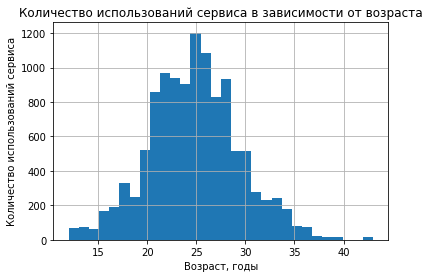

In [51]:
#Визуализируем информацию о возрасте на бесплатном тарифе
hist_function(free_sub['age'], 'Количество использований сервиса в зависимости от возраста', 
              'Возраст, годы', 'Количество использований сервиса')

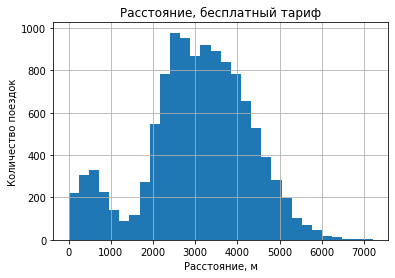

In [52]:
#Визуализируем информацию о расстоянии на бесплатном тарифе
hist_function(free_sub['distance'], 'Расстояние, бесплатный тариф', 
              'Расстояние, м', 'Количество поездок')

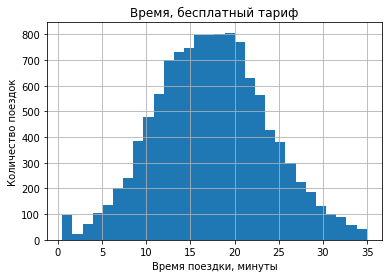

In [53]:
#Визуализируем информацию о времени на бесплатном тарифе
hist_function(free_sub['duration'], 'Время, бесплатный тариф', 'Время поездки, минуты', 'Количество поездок')

In [54]:
#Создадим датафрейм с данными о пользователях с подпиской
ultra_sub = full_data.query("`subscription_type` == 'ultra'")
ultra_sub.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [55]:
ultra_sub.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,6.422308,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,3.414616,0.0,0.0,0.0
min,1.000000,12.000000,244.210438,3.760353,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,12.000000,6.0,0.0,199.0


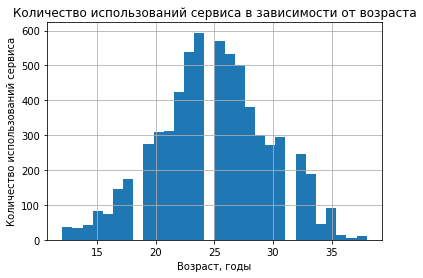

In [56]:
#Визуализируем информацию о возрасте на платном тарифе
hist_function(ultra_sub['age'], 'Количество использований сервиса в зависимости от возраста', 
              'Возраст, годы', 'Количество использований сервиса')

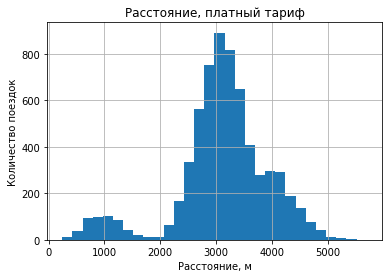

In [57]:
#Визуализируем информацию о расстоянии на платном тарифе
hist_function(ultra_sub['distance'], 'Расстояние, платный тариф', 'Расстояние, м', 'Количество поездок')

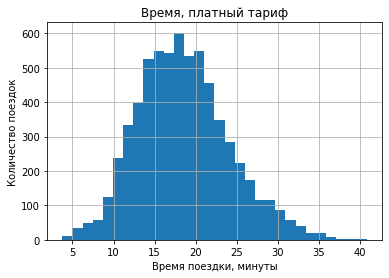

In [58]:
#Визуализируем информацию о времени на платном тарифе
hist_function(ultra_sub['duration'], 'Время, платный тариф', 'Время поездки, минуты', 'Количество поездок')

**Для наглядности, объединим группы разных показателей:**

In [59]:
# Функция сравнения одинаковых столбцов 
# с количественными данными в разных датафреймах
def quantity_go_comparison(data1, data2, column, bins_num, xlabel, ylabel, title, dataname1, dataname2):
    print('Сравнение столбцов:', column)
    
    data1.rename(columns = {column:dataname1})[dataname1].plot.hist(
        bins=bins_num, 
        #xlim=(data_min, data_max),
        alpha=.5, 
        legend=True,
        grid=True
    )
    data2.rename(columns = {column:dataname2})[dataname2].plot.hist(
        bins=bins_num, 
        #xlim=(data_min, data_max),
        alpha=.5, 
        legend=True,
        grid=True
    )
    
    plt.gca().set(xlabel=f'${xlabel}$', ylabel=f'${ylabel}$')
    plt.title(f'{title}')
    plt.show()
    
    print(f"Описание датафрейма 'go_{dataname1}':")
    print(data1[column].describe().round(0))
    
    print(f"\nОписание датафрейма 'go_{dataname2}':")
    print(data2[column].describe().round(0))

In [60]:
# Функции сравнения одинаковых столбцов 
# с качественными данными в разных датафреймах
def quality_go_comparison(data1, data2, column, xlabel, ylabel, title, dataname1, dataname2, sort=False):
    print('Сравнение столбцов:', column)
    
    go_count = pd.DataFrame([
        data1.groupby(column)[column].agg('count'), 
        data2.groupby(column)[column].agg('count')
    ])
    go_count.index = [dataname1, dataname2]
    go_count = go_count.transpose()
    if sort == True:
        if go_count[dataname1].sum() >= go_count[dataname2].sum():
            go_count = go_count.sort_values(by=dataname1)
        else:
            go_count = go_count.sort_values(by=dataname2)
    
    go_count.plot.barh(grid=True)
    plt.gca().set(xlabel=f'${xlabel}$', ylabel=f'${ylabel}$')
    plt.title(f'{title}')
    plt.show()
    
    go_percent_sum = go_count[dataname1].sum() + go_count[dataname2].sum()
    go_percent = go_count / go_percent_sum
    
    print('Значения датафрейма:')
    print(go_count)
    print('\nРаспределение долей всего датафрейма:')
    print(go_percent)
    print('\nОписание датафрейма:')
    print(go_count.describe())

Сравнение столбцов: age


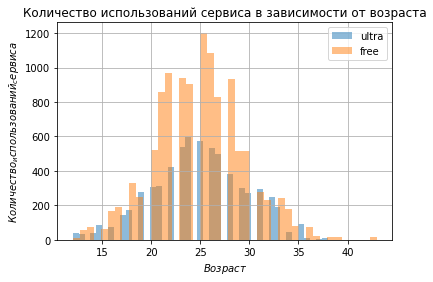

Описание датафрейма 'go_ultra':
count    6500.0
mean       25.0
std         5.0
min        12.0
25%        22.0
50%        25.0
75%        28.0
max        38.0
Name: age, dtype: float64

Описание датафрейма 'go_free':
count    11568.0
mean        25.0
std          4.0
min         12.0
25%         22.0
50%         25.0
75%         28.0
max         43.0
Name: age, dtype: float64


In [61]:
# Срвнение столбцов 'age' в 'ultra_sub' и 'free_sub'
quantity_go_comparison(ultra_sub, free_sub, 'age', int(free_sub['age'].max()), 'Возраст', 'Количество_ использований_ сервиса', 
    'Количество использований сервиса в зависимости от возраста', 'ultra', 'free'
)

Возрастные показатели пользователей с разным типом подписки в целом схожи, за исключением максимального возраста, который на 5 лет больше у пользователей с подпиской ‘free’ и равен 43 годам.

Сравнение столбцов: city


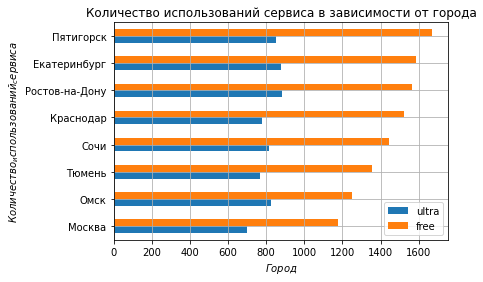

Значения датафрейма:
                ultra  free
city                       
Москва            700  1175
Омск              827  1250
Тюмень            767  1354
Сочи              813  1446
Краснодар         780  1521
Ростов-на-Дону    885  1565
Екатеринбург      876  1585
Пятигорск         852  1672

Распределение долей всего датафрейма:
                   ultra      free
city                              
Москва          0.038743  0.065032
Омск            0.045772  0.069183
Тюмень          0.042451  0.074939
Сочи            0.044997  0.080031
Краснодар       0.043170  0.084182
Ростов-на-Дону  0.048982  0.086617
Екатеринбург    0.048484  0.087724
Пятигорск       0.047155  0.092539

Описание датафрейма:
            ultra         free
count    8.000000     8.000000
mean   812.500000  1446.000000
std     61.923916   173.412802
min    700.000000  1175.000000
25%    776.750000  1328.000000
50%    820.000000  1483.500000
75%    858.000000  1570.000000
max    885.000000  1672.000000


In [62]:
# Срвнение столбцов 'city' в 'ultra_sub' и 'free_sub'
quality_go_comparison(ultra_sub, free_sub, 'city', 'Город', 'Количество_ использований_ сервиса', 
    'Количество использований сервиса в зависимости от города', 'ultra', 'free', True
)

Во всех городах доминирует подписка ‘free’. Пятигорск является лидером по использованию этиго типа подписки (1672 поездок, это 9.25% от общего количества поездок). Ростов-на-Дону является лидером по использованию подписки ‘ultra’ (885 поездок, это 4.9% от общего количества поездок). Минимальное количество поездок совершено в Москве с использованием подписки ‘ultra’ (700 поездок, это 3.87% от общего количества поездок).

Сравнение столбцов: distance


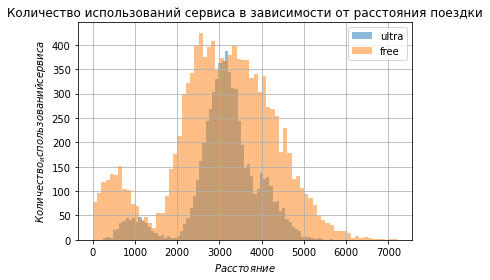

Описание датафрейма 'go_ultra':
count    6500.0
mean     3115.0
std       837.0
min       244.0
25%      2785.0
50%      3149.0
75%      3561.0
max      5700.0
Name: distance, dtype: float64

Описание датафрейма 'go_free':
count    11568.0
mean      3045.0
std       1246.0
min          1.0
25%       2367.0
50%       3115.0
75%       3906.0
max       7211.0
Name: distance, dtype: float64


In [63]:
# Срвнение столбцов 'distance' в 'ultra_sub' и 'free_sub'
quantity_go_comparison(ultra_sub, free_sub, 'distance', int(free_sub['distance'].max()/100), 'Расстояние', 
    'Количество_ использований сервиса', 'Количество использований сервиса в зависимости от расстояния поездки', 'ultra', 'free'
)

Дистанция поездок при использовании подписки ‘free’ более разнообразна. Так максимальная дистанция больше на 1511 метров, а минимальная на 243 метра меньше, чем при использовании подписки ‘ultra’. Об этом же свидетельствует и стандартное отклонение, которое при использовании подписки ‘free’ больше на 409 метров, чем при использовании подписки ‘ultra’. Средняя дистанция при использовании подписки ‘free’ короче. Это следует из того, что среднее значениее на 70 метров, а медиана на 34 метра, меньше, чем при использовании ‘ultra’.

При использовании обоих подписок наблюдается два пика. Первый небольшой пик на меньших дистанциях и второй основной пик на больших дистанциях. Так меньший пик ‘ultra’ находится в районе 1000 метров, а основной в районе 3100 метров с небольшой коррекцией около 4000 метров. Меншьй пик ‘free’ в районе 700 метров, а основной 2500-3500 метров. В целом пики ‘ultra’ более выраженные и имеют меньший разрбос.

Сравнение столбцов: duration


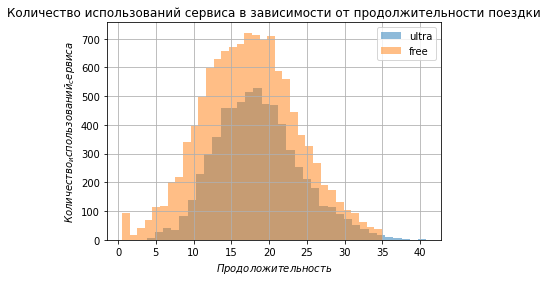

Описание датафрейма 'go_ultra':
count    6500.0
mean       19.0
std         6.0
min         4.0
25%        15.0
50%        18.0
75%        22.0
max        41.0
Name: duration, dtype: float64

Описание датафрейма 'go_free':
count    11568.0
mean        17.0
std          6.0
min          0.0
25%         13.0
50%         17.0
75%         22.0
max         35.0
Name: duration, dtype: float64


In [64]:
# Срвнение столбцов 'duration' в 'ultra_sub' и 'free_sub'
quantity_go_comparison(ultra_sub, free_sub, 'duration', int(free_sub['duration'].max()), 'Продоложительность', 
    'Количество_ использований_ сервиса', 'Количество использований сервиса в зависимости от продолжительности поездки', 
    'ultra', 'free'
)

Продолжительность поездок при использовании подписки ‘free’ немного меньше по всем показателям, чем при использовании ‘ultra’. Например, минимальное время меньше на 3.26 минут, а максимальное меньше на 5.88 минут. В обоих случаях количество поездок относительно нормально распределено в зависимости от их продолжительности. Пик количества поездок приходится на 17-18 минут. При использовании подписки ‘free’ наблюдается пик в около 100 поездок с продолжительностью около 1 минуты.

Сравнение столбцов: month


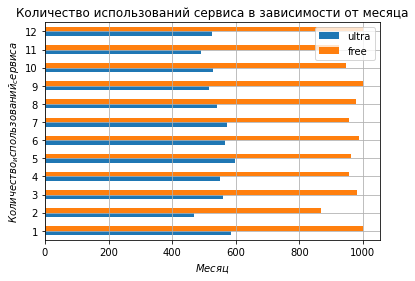

Значения датафрейма:
       ultra  free
month             
1        584  1001
2        468   868
3        561   983
4        551   955
5        597   963
6        565   988
7        574   955
8        540   978
9        515  1002
10       529   946
11       492   926
12       524  1003

Распределение долей всего датафрейма:
          ultra      free
month                    
1      0.032322  0.055402
2      0.025902  0.048041
3      0.031049  0.054406
4      0.030496  0.052856
5      0.033042  0.053299
6      0.031271  0.054682
7      0.031769  0.052856
8      0.029887  0.054129
9      0.028503  0.055457
10     0.029278  0.052358
11     0.027230  0.051251
12     0.029002  0.055513

Описание датафрейма:
            ultra         free
count   12.000000    12.000000
mean   541.666667   964.000000
std     38.120224    38.863397
min    468.000000   868.000000
25%    521.750000   952.750000
50%    545.500000   970.500000
75%    567.250000   991.250000
max    597.000000  1003.000000


In [65]:
# Срвнение столбцов 'month' в 'ultra_sub' и 'free_sub'
quality_go_comparison(ultra_sub, free_sub, 'month', 'Месяц', 'Количество_ использований_ сервиса', 
    'Количество использований сервиса в зависимости от месяца', 'ultra', 'free',
)

Сезонность использования разного типа подписки схожа за исключением медианы, которая у подписчиков ‘ultra’ приходится на июнь, а у подписчиков ‘free’ на июль. При использовании обоих типов подписок наблюдаются спады пользовательской активности в феврале и ноябре. Максимум поездок с подпиской ‘ultra’ в мае (597 поездок, это 3.3% от всех поездок). Максимумы поездок с подпиской ‘free’ в январе (1001 поездка, это 5.54% от всех поездок), сентябре (1002 поездки) и декабре (1003 поездки). При использовании подписки ‘free’ нет выраженной сезонности, кроме спдов в феврале и ноябре. При использовании подписки ‘ultra’ наблюдается более выраженная сезонность. Количество поездок растет с февраля по май, а затем медленно снижается до ноября.

**Вывод**

Объединили данные о пользователях, поездках и тарифах в один датафрейм - `full_data`.

Выделили два датафрейма на основе `full_data`:
- `free_sub` - Информация о пользователях с бесплатным тарифом
- `ultra_sub` - Информация о пользователях с платным тарифом

Визуализировали информацию о расстоянии и времени для каждого из тарифов.

Для бесплатного тарифа время поездки составляет от 10 до 25 минут, и проезжают от 2 до 4,5 км, есть пользователи, которые проехали даже 6, 6.5 км.

Платный тариф. В основном время укладывается в промежуток от 13 до 23 минут. Пик расстояния приходится на 3км.

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе. 

Общее количество поездок с исползьзованием подписки ‘free’ на 5068 больше, чем с использованием подписки ‘ultra’, и составляет 11568.

Возрастные показатели пользователей с разным типом подписки в целом схожи, за исключением максимального возраста, который на 5 лет больше у пользователей с подпиской ‘free’.

Дистанция поездок при использовании подписки ‘free’ более разнообразна. Так максимальная дистанция больше на 1512 метров, а минимальная на 243 метра меньше, чем при использовании подписки ‘ultra’. Об этом же свидетельствует и стандартное отклонение, которое при использовании подписки ‘free’ больше на 409 метров, чем при использовании подписки ‘ultra’. Средняя дистанция при использовании подписки ‘free’ короче. Это следует из того, что среднее значениее на 70 метров, а медиана на 34 метра, меньше, чем при использовании ‘ultra’.

Продолжительность поездок при использовании подписки ‘free’ немного меньше по всем показателям, чем при использовании ‘ultra’. Например, минимальное время меньше на 3.2 минут, а максимальное меньше на 5.8 минут.

Сезонность использования разного типа подписки схожа за исключением медианы, которая у подписчиков ‘ultra’ приходится на июнь, а у подписчиков ‘free’ на июль. При использовании обоих типов подписок наблюдаются спады пользовательской активности в феврале и ноябре. Максимум поездок с подпиской ‘ultra’ в мае (597 поездок, это 3.3% от всех поездок). Максимумы поездок с подпиской ‘free’ в январе (1001 поездка, это 5.54% от всех поездок), сентябре (1002 поездки) и декабре (1003 поездки). При использовании подписки ‘free’ нет выраженной сезонности, кроме спдов в феврале и ноябре. При использовании подписки ‘ultra’ наблюдается более выраженная сезонность. Количество поездок растет с февраля по май, а затем медленно снижается до ноября.

Во всех городах доминирует подписка ‘free’. Пятигорск является лидером по использованию этиго типа подписки (1672 поездок). Ростов-на-Дону является лидером по использованию подписки ‘ultra’ (885 поездок).

# Шаг 5. Подсчёт выручки

**Создание датафрейма, агрегированного по пользователям, на основе ‘full_data’**

Требуется найти для каждого пользователя за каждый месяц:

- Суммарное расстояние;
- Количество поездок;
- Суммарное время.

In [66]:
# Округление продолжительности поездок в duration в общей таблице 'total_go'
full_data['duration'] = np.ceil(full_data['duration'])

# Создание сводной таблицы
users_months_go = full_data.pivot_table(
    index=('user_id', 'month'), 
    values=('distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'), 
    aggfunc=('count', 'sum'))

# Переименование "двухэтажных" названий столбцов
users_months_go.columns = [
    'count', 'distance', 
    'count2', 'duration', 
    'count3', 'minute_price',
    'count4', 'start_ride_price', 
    'count5', 'subscription_fee'
]

# Удаление дублирующих столбцов с подсчитанным количеством строк 
users_months_go = users_months_go.drop(['count2', 'count3', 'count4', 'count5'], axis=1)

# Приведение столбцов с ценами к целевому состоянию
users_months_go['start_ride_price'] = users_months_go['start_ride_price'] / users_months_go['count']
users_months_go['minute_price'] = users_months_go['minute_price'] / users_months_go['count']

#users_months_go.loc[users_months_go['minute_price'] > 0] = 8
users_months_go['subscription_fee'] = users_months_go['subscription_fee'] / users_months_go['count']

users_months_go

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294      42.0           6.0               0.0   
        4          1    754.159807       7.0           6.0               0.0   
        8          2   6723.470560      46.0           6.0               0.0   
        10         2   5809.911100      32.0           6.0               0.0   
        11         3   7003.499363      56.0           6.0               0.0   
...              ...           ...       ...           ...               ...   
1534    6          2   3409.468534      26.0           8.0              50.0   
        8          2   7622.453034      48.0           8.0              50.0   
        9          1   4928.173852      23.0           8.0              50.0   
        11         4  13350.015305      78.0           8.0              50.0   
        12         1   2371.711192      16.0           8.0              50.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0  
...                         ...  
1534    6                   0.0  
        8                   0.0  
        9                   0.0  
        11                  0.0  
        12                  0.0  

[11331 rows x 6 columns]

Добавление столбца в агрегированный датафрейм с помесечной выручкой по каждому пользователю

Найдём суммарное расстояние, кличество поездок и суммарное время для каждого пользователя за каждый месяц.

In [67]:
# Расчет и округление выручки
users_months_go['revenue'] = (
    (users_months_go['start_ride_price'] * users_months_go['count']) 
    + (users_months_go['minute_price'] * users_months_go['duration']) 
    + users_months_go['subscription_fee']
)
users_months_go['revenue'] = users_months_go['revenue'].astype('uint16')

# Удаление столбцов со вспомогательными данными
users_months_go = users_months_go.drop(['start_ride_price', 'minute_price'], axis=1)

users_months_go.head(10)

count      distance  duration  subscription_fee  revenue
user_id month                                                          
1       1          2   7027.511294      42.0             199.0      451
        4          1    754.159807       7.0             199.0      241
        8          2   6723.470560      46.0             199.0      475
        10         2   5809.911100      32.0             199.0      391
        11         3   7003.499363      56.0             199.0      535
        12         2   6751.629942      28.0             199.0      367
2       3          3  10187.723006      63.0             199.0      577
        4          2   6164.381824      40.0             199.0      439
        6          1   3255.338202      14.0             199.0      283
        7          2   6780.722964      48.0             199.0      487

**Итог**

Создали новый датафрейм с агрегированными данными на основе датафрейма с объединенными данными (`full_data`).

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
Также добавили столбец с помесячной выручкой, которую принес каждый пользователь.

# Шаг 6. Проверка гипотез

1) Проверим гипотезу: пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.
Если гипотеза подтвердится, то пользователи с подпиской могут быть «выгоднее» для компании.

H_0: Время (`duration`) пользователей на подписке `ultra` = время (`duration`) пользователей на подписке `free`

H_1: Время (`duration`) пользователей на подписке `ultra` > время (`duration`) пользователей на подписке `free`

Выберем уровень статистической значимости 5%:
alpha = 0.05

In [68]:
ultra = ultra_sub['duration'] 
free = free_sub['duration']
results = st.ttest_ind(ultra, free, alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


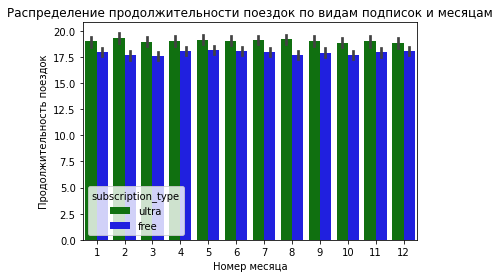

In [69]:
ax = sns.barplot(x = 'month', y = 'duration', hue = "subscription_type", data = full_data, palette = ['green', 'blue'])
ax.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

**Вывод**

Проверили гипотезу, отвергли гипотезу о том, что время поездки пользователей на тарифе `ultra` равно времени поездки пользователей на тарифе `free`. Из графика видно, что верна гипотеза H1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проверим гипотезу: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

H_0: Расстояние (`distance`) пользователей на подписке `ultra` = 3130 метров

H_1: Расстояние (`distance`) пользователей на подписке `ultra` > 3130 метров

Выберем уровень статистической значимости 5%:
alpha = 0.05

In [70]:
ultra_dist = ultra_sub['distance']
interested_value = 3130.0
alpha = 0.05

results = st.ttest_1samp(ultra_dist, interested_value, alternative = 'greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


**Вывод**

Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе `ultra` больше 3130 метров.

3) Проверим гипотезу: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

H_0: Средняя выручка от поездок с разной подпиской равна.

H_1: Средняя выручка от поездок с использованием подписки ‘ultra’ выше, чем выручка с ипользованием подписки ‘free’.

Выберем уровень статистической значимости 5%:
alpha = 0.05

In [71]:
results = st.ttest_ind(
    users_months_go.loc[users_months_go['subscription_fee'] > 0, 'revenue'],
    users_months_go.loc[users_months_go['subscription_fee'] == 0, 'revenue'],
    equal_var = False,
    alternative = 'greater'
)

print(results.pvalue)
if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

8.874140893976874e-40
Отвергаем нулевую гипотезу


**Вывод**

Не получилось отвергнуть нулевую гипотезу о том, что средняя выручка от поездок с использованием подписки ‘ultra’ (больше или) равна средней выручке с ипользованием подписки ‘free’.

Значит, как минимум, выручка от подписки ‘ultra’ не меньше, чем от плитки ‘free’, и её следует развивать.

4) Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Сначала требуется провести сравнение выборок на предмет соответствия уникальных пользователей в них.

Если списки уникальных пользователей в них совпадают, то выборки зависимы и для проверки гипотезы потребуется тест st.ttest_rel(before, after, alternative=’greater’)

# Шаг 7. Распределения

**Задача №1.** Требуется выполнить план по продлению подписки 100 клиентами путем рассылки промокодов. Ранее вероятность продления была 10%. Требуется обеспечить выполнение плана с вероятностью неуспеха не более 5%. Построить график и ответить на вопрос. Сколько нужно разослать промокодов?

In [72]:
# Функция расчета количества успешных экспериментов Бернулли
# путем аппроксимации биномиального распределения нормальным
def cnsbe(n, p, x):
    # Расшифровка названия функции:
    # cnsbe - calculation of the number of successful Bernoulli experiments 
    # by approximating the binomial distribution by the normal
    # (расчет количества успешных экспериментов Бернулли 
    # путем аппроксимации биномиального распределения нормальным)
    
    # Параметры биноминального распределения:
    # n - количество экспериментов
    # p - вероятность успеха
    
    # x - вероятность расчитываемого значения
    
    # Расчет параметров нормального распределения
    mu = n * p
    sigma = (n * p * (1 - p))**.5
    # Расчет нормального распределения
    distr = st.norm(mu, sigma)
    
    # Расчет значения для заданной вероятности x
    result = distr.ppf(x)
    
    # Построение графика
    arange = np.arange(
        (mu - 4 * sigma), 
        (mu + 4 * sigma), 
        1
    )
    plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
    plt.axvline(x=result, color='red')
    plt.show()
    
    return result

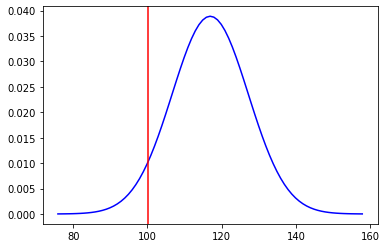

100.02841955223582

In [73]:
cnsbe(1169, 0.1, 0.05)

Требуется разослать 1169 промокодов, которые приводят к продлению подписки с вероятностью 10%, чтобы 100 клиентов продлили подписку с вероятностью неуспеха не более 5%.


**Альтернативное решение**

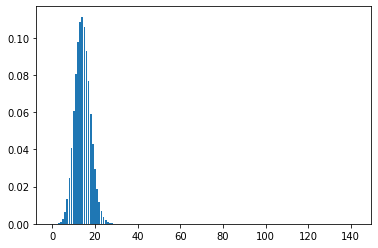

Требуется произвести 142 действиядля получения 10 успешных результатов с вероятностью 95.0% при вероятности успеха 10.0%.


In [74]:
# Функция поиска количества всех попыток экспериментов Бернули n
# которые приводят к желаемому количеству успешных попыток kn
# с определенной вероятностью kp при вероятносте успеха p
def search_binom_n(kn, kp, p):
    # kn - требуемое количество успешных попыток
    # p  - известная вероятность успешных попыток
    # kp - с какой вероятностью нужно получить kn
    kp = 1 - kp
    
    # Общее количество попыток n должно быть не менее 
    # количества успешных попыток kn
    n = kn
    # Тригер успеха
    result = False
    
    # Повторять цикл, пока количество всех попыток n не станет достаточным 
    # для получения требуемого количества успешных попыток kn с вероятностью kp
    while result == False:
        # Вероятности
        distr = []
        # Значения
        k_nums = []
        
        # Построение биноминального распределения
        for k in range(0, n + 1):
            choose = factorial(n) / (factorial(k) * factorial(n - k))
            prob = choose * p**k * (1 - p)**(n - k)
            distr.append(prob)
            k_nums.append(k)
        
        # Проверка параметров распределения
        # на соответствие условиям
        p_sum = 0
        j = 0
        # Сложение вероятностей полученного биноминального распределения
        # до получения значения 
        for i in distr:
            p_sum += i
            j += 1
            # Если сумма сложенных вероятностей равна 
            # ожидаемой вероятности pk получения pn, 
            # то завершить цикл сложения
            if p_sum >= kp: break
        
        # Если значением k при вероятности kp меньше kn,
        # то увеличить n и продолжить расчеты
        if k_nums[j] < kn:
            n += 1
        # Если найдено такое n, которое дает результат kn 
        # с вероятностью kp, то завершить расчеты 
        else:
            result = True
            plt.bar(k_nums, distr);
            plt.show()
            break
    
    return n

k = 10
kp = 0.95
p = 0.1
print(f'Требуется произвести {search_binom_n(k, kp, p)} действия\
для получения {k} успешных результатов с вероятностью {kp*100}% при вероятности успеха {p*100}%.')

Требуется произвести 142 действия для получения 10 успешных результатов с вероятностью 95.0% при вероятности успеха 10.0%.
Идея фунцкии верная. Однако, для получения результата не хватает вычислительных ресурсов при расчете факториалов с заданными параметрами. Вероятно, есть схожая схема расчета, менее требовательная к вычислительным ресурсам.


С помощью созданной функции получилось произвести расчеты для выполнения плана в 10 раз меньше. Для 10 продлений подписки с вероятностью 95%, требуется разослать 142 промокода, которые приводят к продлению подписки с вероятностью 10%. Исходя из полученного результата можно предположить, что при увеличении количества плановых продлений в 10 раз, также увеличится количество разосланных промокодов приблизительно в 10 раз. Если это так, то требуется разослать 1420 промокодов.


**Задача №2.** Планируется разослать клиентам 1 млн. уведомлений, которые клиенты открывают с вероятностью 40%. Требуется с помощью аппроксимации построить график распределения и оценить вероятность того, что не более 399.5 тыс. клиентов откроют уведомления.

In [75]:
# Функция расчета вероятности проведения успешных экспериментов Бернули
# путем аппроксимации биномиального распределения нормальным
def cpsbe(n, p, x):
    # Расшифровка названия функции:
    # cpsbe - calculation of the probability of successful Bernoulli experiments
    # by approximating the binomial distribution by the normal
    # (расчет вероятности проведения успешных экспериментов Бернули 
    # путем аппроксимации биномиального распределения нормальным)
    
    # Параметры биноминального распределения:
    # n - количество экспериментов
    # p - вероятность успеха
    
    # x - заданное значение, для которого расчитывается вероятность
    
    # Расчет параметров нормального распределения
    mu = n * p
    sigma = (n * p * (1 - p))**.5
    # Расчет нормального распределения
    distr = st.norm(mu, sigma)
    
    # Расчет вероятности для заданного значения x
    result = distr.cdf(x)
    
    # Построение графика
    arange = np.arange(
        (mu - 4 * sigma), 
        (mu + 4 * sigma), 
        1
    )
    plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
    plt.axvline(x=x, color='red')
    plt.show()
    
    return result

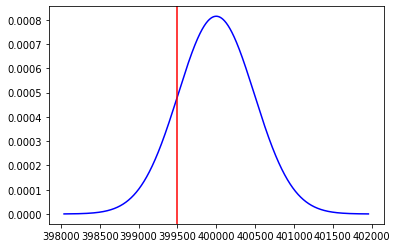

0.15371708296369768

In [76]:
cpsbe(1000000, .4, 399500)

**Вывод**

Не более 399.5 тыс. клиентов откроют уведомления с вероятностью 15.37%, если разослать 1 млн. уведомлений, которые открывают клиенты с вероятностью 40%.

# Шаг 8. Выводы

Основная цель проекта достигнута. Проанализированы данные сервиса аренды самокатов GoFast и проверены некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Проделанная работа**

Загрузили 3 датафрейма: с пользователями, информацией о поездках, информацией о подписках. 

Дальше проверили данные на пропуски, их не оказалось ни в одной таблице. Поменяли тип данных у столбца `date` из датафрейма `data_riders` к типу даты. Также добавили столбец `month` с номером месяца. И удалили дубликаты строк из датафрейма с пользователями.

Провели исследовательский анализ данных:

- Вывели, что количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168. 
- Пользователей, использующих бесплатную подписку больше - 835 человек, что является ~54% от общего числа пользователей. На платной подписке сидит 699 пользователей, что соответственно является ~46%.
- Возраст пользователей укладывается в промежуток от 20 до 30 лет
- В основном пользователи проезжают от 2.5 км до 4 км.
- Чаще всего длительность поездки состовляет 13 - 22 минут

Объединили данные о пользователях, поездках и подписках в один датафрейм. На основе объединенного датафрейма создали еще 2 датафрейма:
- Для пользователей с `ultra` подпиской
- Для пользователей с `free` подпиской

Дальше визуализировали информацию о расстоянии и времени поездки для пользоватей каждого тарифа.

- Для бесплатного тарифа время поездки составляет от 10 до 25 минут, и проезжают от 2 до 4,5 км, есть пользователи, которые проехали даже 6, 6.5 км.
- Платный тариф. В основном время укладывается в промежуток от 13 до 23 минут. Пик расстояния приходится на 3км.

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датафрейм.
Добавили в датафрейм столбец с помесячной выручкой.

Проверили гипотезы:

- Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе
    - Отвергли нулевую гипотезу
- Пользователи с подпиской проезжают расстояние больше 3130 метров за одну поездку
    - Не удалось отвергнуть нулевую гипотезу
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки
    - Не удалось отвергнуть нулевую гипотезу
    
Построены распределения:

- Требуется разослать 1169 промокодов, которые приводят к продлению подписки с вероятностью 10%, чтобы 100 клиентов продлили подписку с вероятностью неуспеха не более 5%.
- 399.5 тыс. клиентов откроют уведомления с вероятностью 15.37%, если разослать 1 млн. уведомлений, которые открывают клиенты с вероятностью 40%.